# Machine Learning Pipeline for Renewable Energy Forecasting

This notebook demonstrates ML models for predicting renewable energy generation using Random Forest algorithms with Bayesian optimization. It covers wind turbine power output forecasting and hydropower inflow prediction using real-world datasets.

## 1. Wind Power Forecasting

In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

# Hyperparameter optimization
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [4]:
# data import and preprocessing
df = pd.read_csv('data/wtbdata_245days-2.csv')
df['hour'] = pd.to_datetime(df['Tmstamp']).dt.hour
df['minute'] = pd.to_datetime(df['Tmstamp']).dt.minute
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)

# Wind directions
df['Wdir_sin'] = np.sin(np.radians(df['Wdir']))
df['Wdir_cos'] = np.cos(np.radians(df['Wdir']))
df['Ndir_sin'] = np.sin(np.radians(df['Ndir']))
df['Ndir_cos'] = np.cos(np.radians(df['Ndir']))


df['Patv_lag1'] = df.groupby('TurbID')['Patv'].shift(1)
df['Patv_lag6'] = df.groupby('TurbID')['Patv'].shift(6)  # 1 hour ago
df['Patv_lag144'] = df.groupby('TurbID')['Patv'].shift(144)  # 24 hours ago

df.head()

/var/folders/gr/mhlc8kfs39b7v4v54d1fd4bc0000gn/T/ipykernel_78529/2438828282.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/var/folders/gr/mhlc8kfs39b7v4v54d1fd4bc0000gn/T/ipykernel_78529/2438828282.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,...,hour_cos,minute_sin,minute_cos,Wdir_sin,Wdir_cos,Ndir_sin,Ndir_cos,Patv_lag1,Patv_lag6,Patv_lag144
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.000000e+00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,...,1.0,8.660254e-01,0.5,-0.069582,0.997576,0.437116,0.899405,NaN,NaN,NaN
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,...,1.0,8.660254e-01,-0.5,-0.038039,0.999276,0.356901,0.934142,494.66,NaN,NaN
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,...,1.0,5.665539e-16,-1.0,-0.012741,0.999919,0.356901,0.934142,509.76,NaN,NaN
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,...,1.0,-8.660254e-01,-0.5,0.015533,0.999879,0.356901,0.934142,542.53,NaN,NaN


In [5]:
# Handle irregularities in data
print(f"missing values before getting rid of irregularties: {df.isnull().sum().sum()}")

mask_abnormal = (
    (df['Patv'] < 0) | # negative power
    ((df['Wspd'] < 1) & (df['Patv'] > 10)) | # too muhc power for low wind
    ((df['Wspd'] < 2) & (df['Patv'] > 100)) | # too much power for low wind
    ((df['Wspd'] < 3) & (df['Patv'] > 200)) | # too much power for low wind
    ((df['Wspd'] > 2.5) & (df['Patv'] == 0)) | # no power for reasonable wind
    ((df['Wspd'] == 0) & (df['Wdir'] == 0) & (df['Etmp'] == 0)) | # sensor error
    (df['Etmp'] < -21) | # external temp outside of reasonable range
    (df['Itmp'] < -21) | # internal temp outside of reasonable range
    (df['Etmp'] > 60) | # external temp outside of reasonable range
    (df['Itmp'] > 70) | # internal temp outside of reasonable range
    (df['Wdir'] > 180) | (df['Wdir'] < -180) | # wind direction out of range
    (df['Ndir'] > 720) | (df['Ndir'] < -720) | # nacelle direction out of range
    (df['Pab1'] > 89) | (df['Pab2'] > 89) | (df['Pab3'] > 89) # pitch angle out of range
)

columns_to_nan = df.columns.difference(['TurbID', 'Day'])
df.loc[mask_abnormal, columns_to_nan] = np.nan

print(f"missing values after getting rid of irregularties: {df.isnull().sum().sum()}")

missing values before getting rid of irregularties: 862024
missing values after getting rid of irregularties: 38203524


In [6]:
# Drop rows with missing values and reset index
df_cleaned = df.dropna().reset_index(drop=True)
print(f"shape after cleaning: {df_cleaned.shape}")

shape after cleaning: (3072427, 26)


In [ ]:
sns.pairplot(df_cleaned[['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Patv']])
plt.suptitle('Pairplot of Wind Speed, Power Output, External Temp, Internal Temp', y=1.02)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


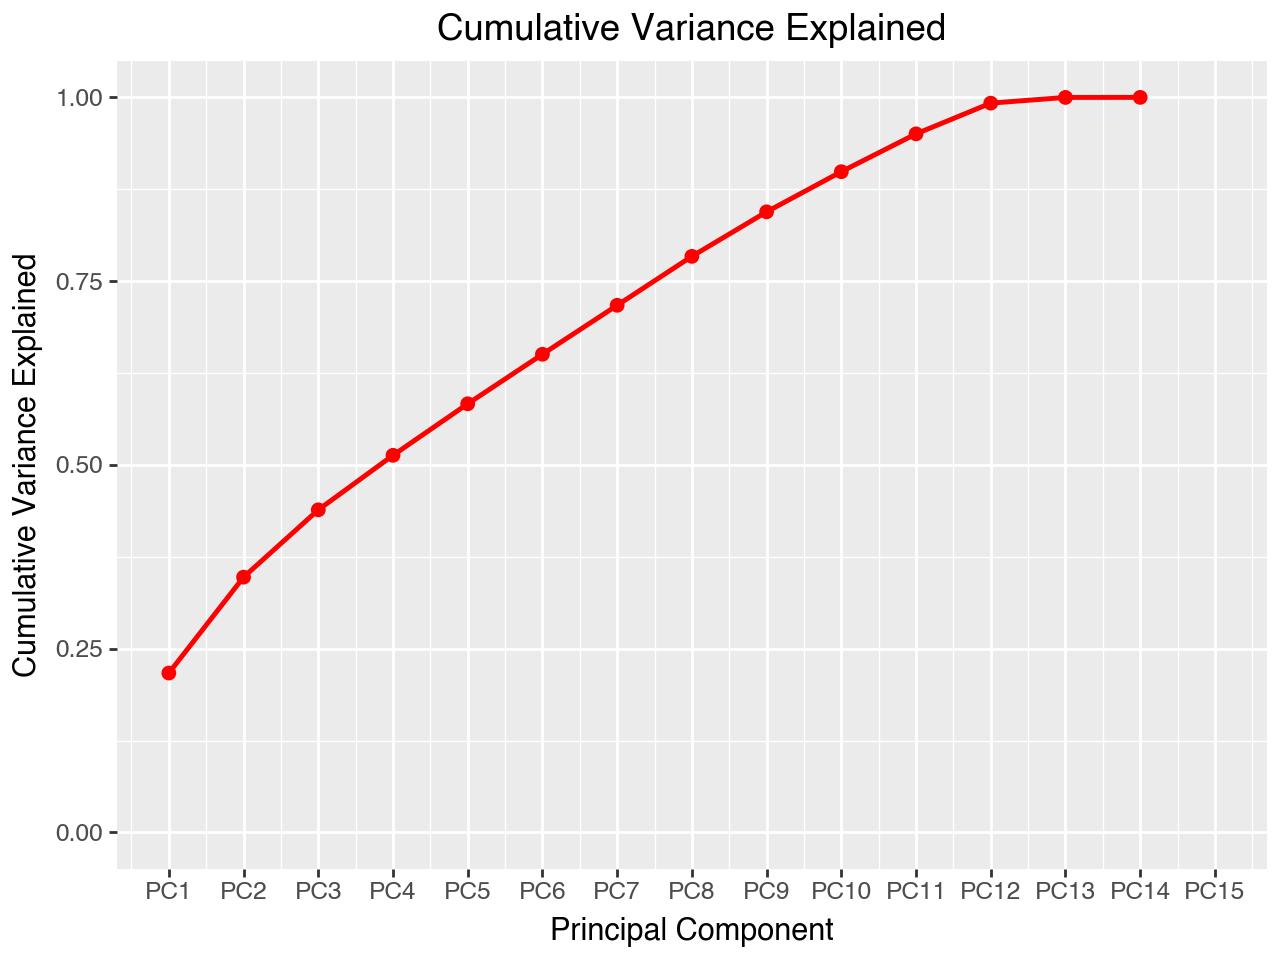

In [8]:
features = [
    'Wspd',
    'Wdir_sin', 'Wdir_cos',  
    'Etmp', 'Itmp',
    'Ndir_sin', 'Ndir_cos',  
    'Pab1', 'Pab2', 'Pab3',
    'Prtv',
    'hour_sin', 'hour_cos',  
    'minute_sin', 'minute_cos'  
]

# Standardize the features
X = df_cleaned.loc[:, features].values
X_scaled = StandardScaler().fit_transform(X)

pca = PCA().fit(X_scaled)
explained_variance = pca.explained_variance_ratio_

pc_df = pd.DataFrame({
    'PC_number': range(1, len(explained_variance) + 1),
    'Variance Explained': explained_variance,
    'Cumulative Variance': explained_variance.cumsum()  
})

(
    ggplot(pc_df, aes(x='PC_number', y='Cumulative Variance')) +
    geom_line(color='red', size=1) +
    geom_point(color='red', size=2) +
    scale_x_continuous(breaks=range(1, len(explained_variance) + 1),
                       labels=[f'PC{i}' for i in range(1, len(explained_variance) + 1)]) +
    scale_y_continuous(limits=[0, 1]) +
    labs(title='Cumulative Variance Explained',
         x='Principal Component',
         y='Cumulative Variance Explained')
)

In [9]:
# Random Forest model to predict wind energy - hyperparameter tuning with Bayesian Optimization

features = [
    'Wspd',
    'Wdir_sin', 'Wdir_cos',
    'Etmp', 'Itmp',
    'Ndir_sin', 'Ndir_cos',
    'hour_sin', 'hour_cos',
    'minute_sin', 'minute_cos'
]

samples_per_turbine = 10000 // df_cleaned['TurbID'].nunique()
df_sample = df_cleaned.groupby('TurbID').head(samples_per_turbine).reset_index(drop=True)
df_sample = df_sample.sort_values(['TurbID', 'Tmstamp']).reset_index(drop=True)

split_idx = int(len(df_sample) * 0.67)
train_data = df_sample.iloc[:split_idx]
test_data = df_sample.iloc[split_idx:]

scaler = StandardScaler()
X_train = scaler.fit_transform(train_data[features].values)
X_test = scaler.transform(test_data[features].values)
y_train = train_data['Patv'].values
y_test = test_data['Patv'].values

# Define search space
search_spaces = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical(['sqrt', 'log2', 0.5, 0.7, 1.0]),
    'bootstrap': Categorical([True, False])
}

# Create BayesSearchCV object
opt = BayesSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    search_spaces,
    n_iter=30,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    random_state=42,
    verbose=0
)

# Fit the optimizer
opt.fit(X_train, y_train)

# Best parameters
print("Best parameters:", opt.best_params_)
print("Best CV score:", -opt.best_score_)

# Evaluate on test set
y_pred = opt.predict(X_test)
print(f'\nTest Set Performance:')
print(f'MSE: {mean_squared_error(y_test, y_pred):.4f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.4f}')
print(f'R²: {r2_score(y_test, y_pred):.4f}')

Best parameters: OrderedDict([('bootstrap', True), ('max_depth', 19), ('max_features', 0.7), ('min_samples_leaf', 7), ('min_samples_split', 20), ('n_estimators', 500)])
Best CV score: 43.68386373759515

Test Set Performance:
MSE: 8215.2058
MAE: 55.6072
R²: 0.7537


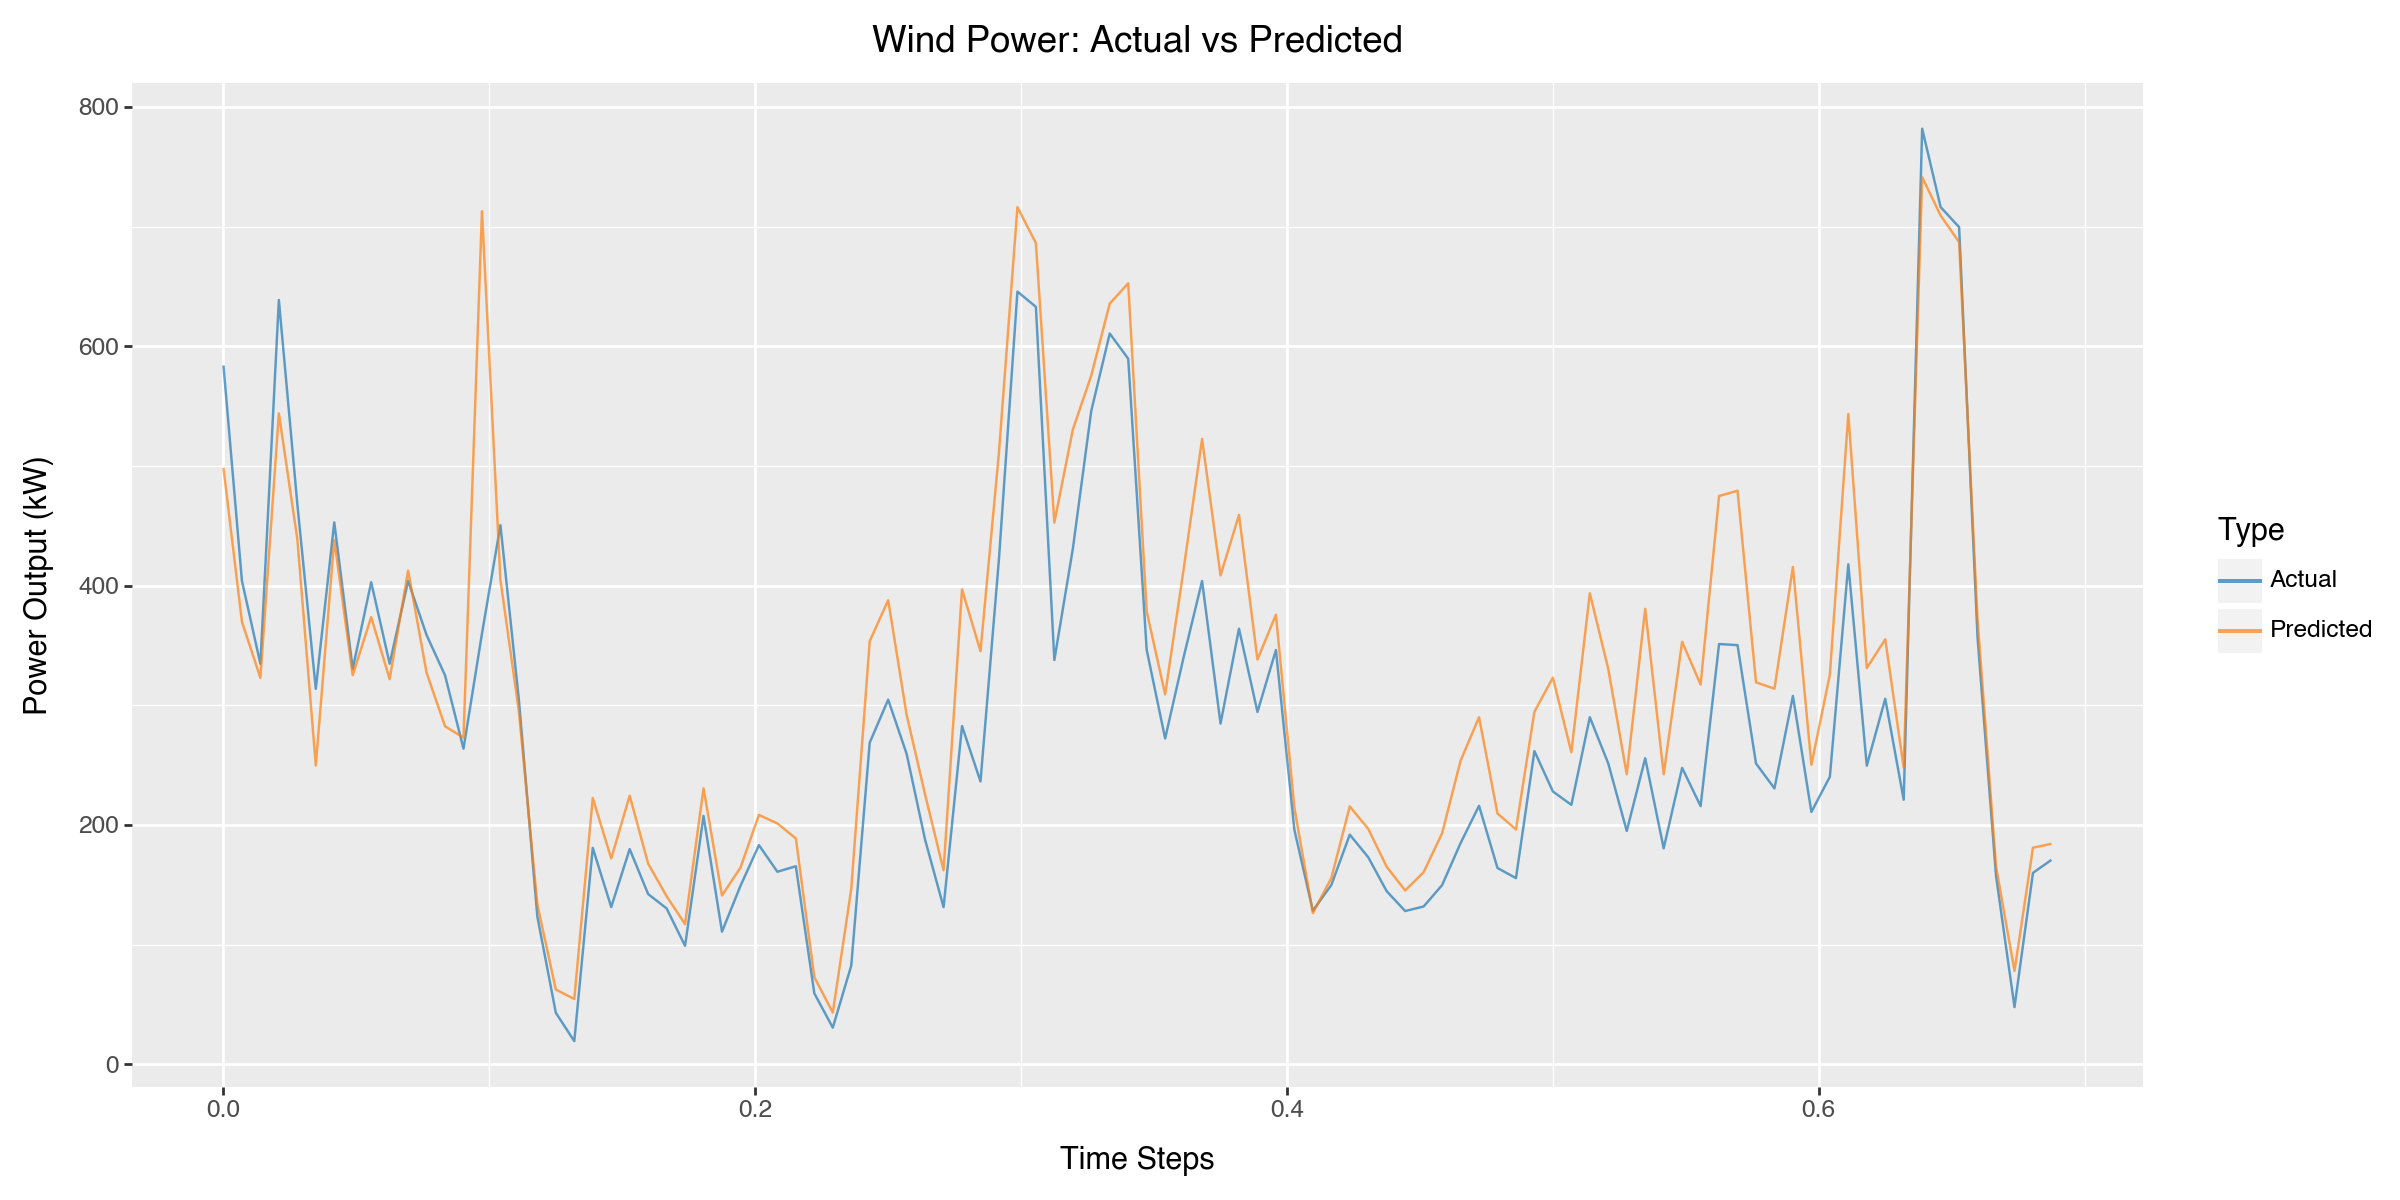

In [10]:
# plot to compare actual vs predicted
n_points = 100  
comparison_df = pd.DataFrame({
    'Time_Index': range(n_points),
    'Actual': y_test[:n_points],
    'Predicted': y_pred[:n_points]
})

comparison_df['day'] = comparison_df['Time_Index'] * 10 / 60 /24
plot_df = pd.melt(comparison_df,
                  id_vars=['day'],
                  value_vars=['Actual', 'Predicted'],
                  var_name='Type',
                  value_name='Power')

(
    ggplot(plot_df, aes(x='day', y='Power', color='Type')) +
    geom_line(alpha=0.7) +
    scale_color_manual(values=['#1f77b4', '#ff7f0e']) +
    labs(title='Wind Power: Actual vs Predicted',
      x='Time Steps',
      y='Power Output (kW)') +
    theme(figure_size=(12, 6))
 )

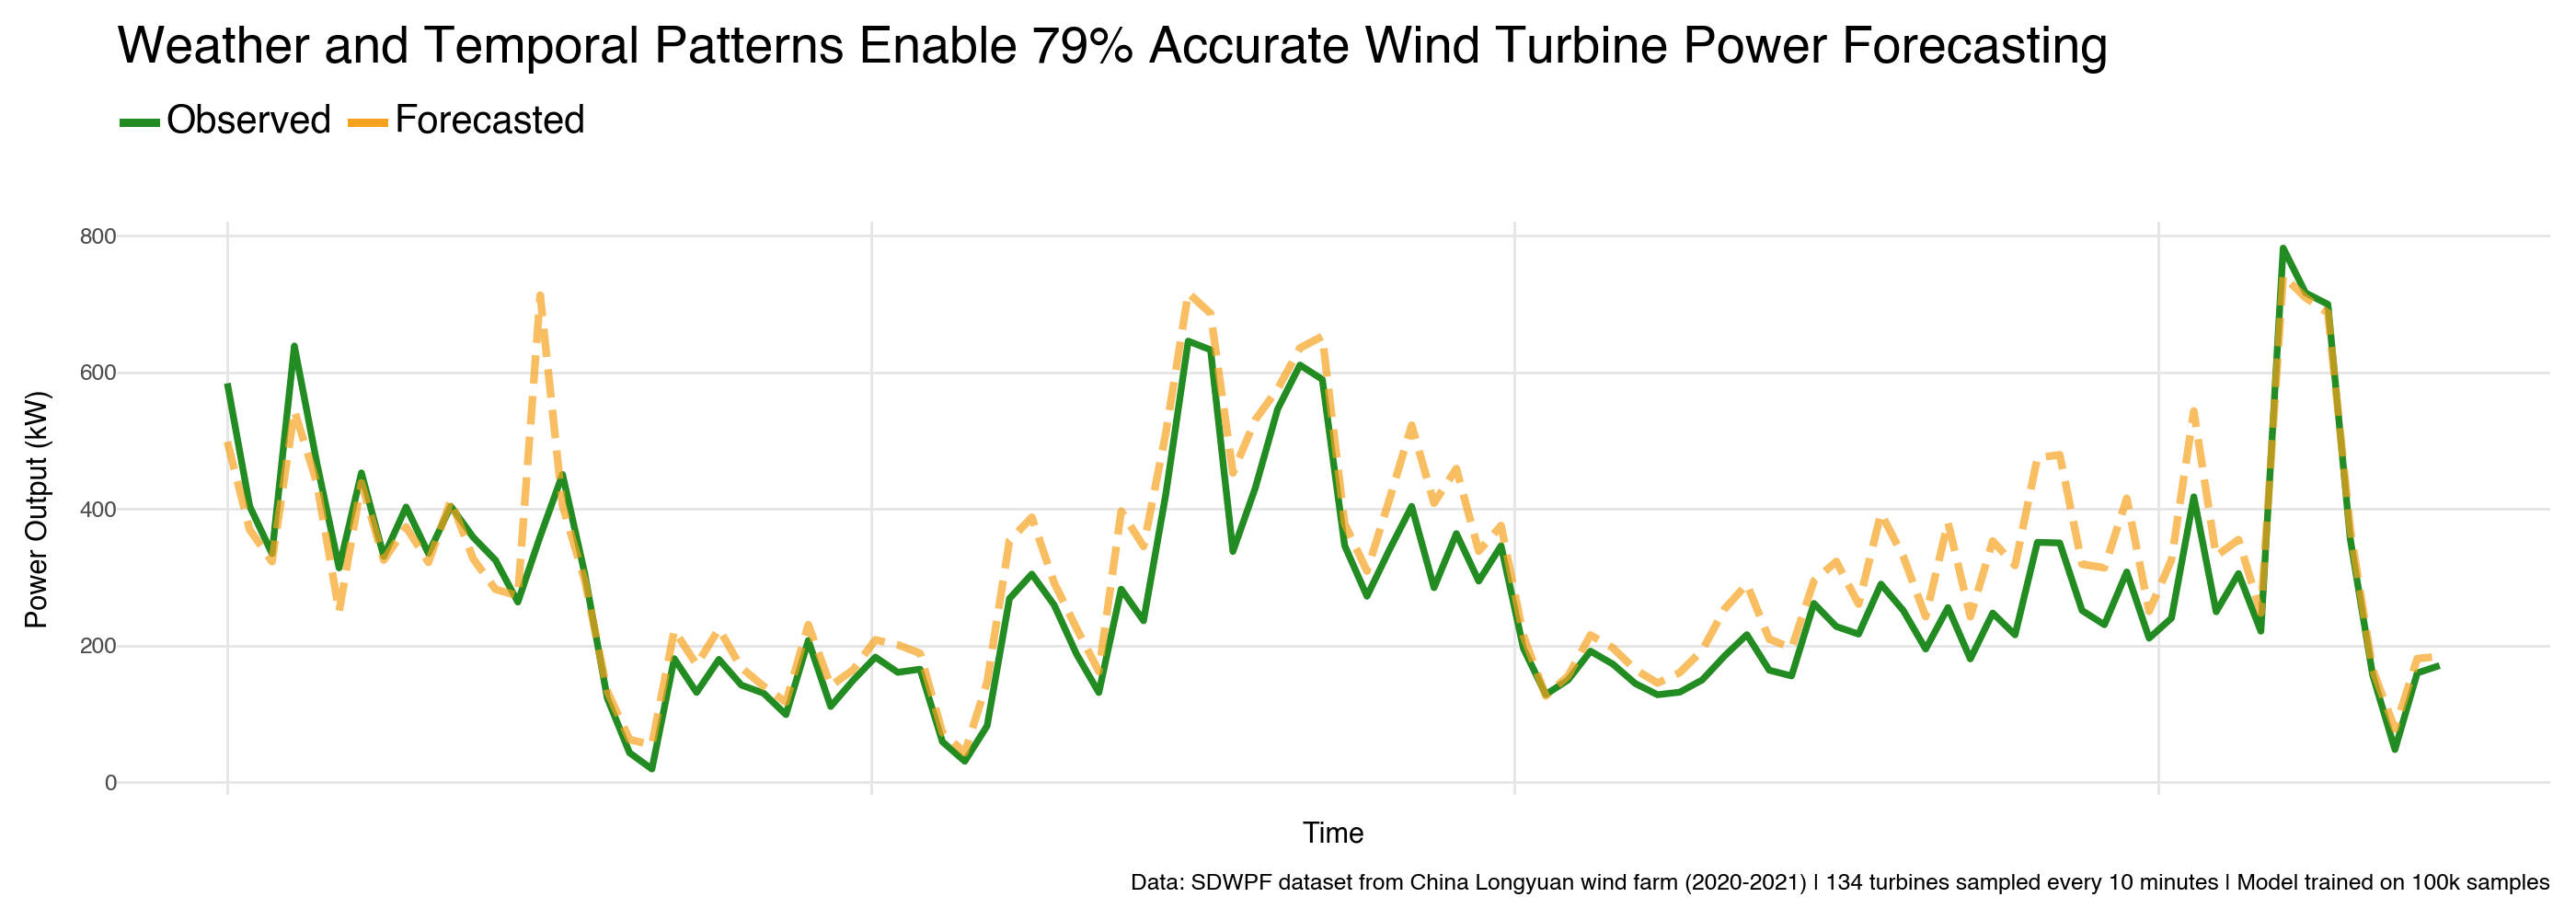

In [11]:
plot_df['Type'] = plot_df['Type'].str.replace('Actual', 'Observed')
plot_df['Type'] = plot_df['Type'].str.replace('Predicted', 'Forecasted')
plot_df['Type'] = pd.Categorical(plot_df['Type'], categories=['Observed', 'Forecasted'], ordered=True)
plot_df = plot_df.sort_values('Type')

(
ggplot(plot_df, aes(x='day', y='Power', color='Type')) 
+ geom_line(data=plot_df[plot_df['Type']=='Observed'], size=1.5, alpha=1)
+ geom_line(data=plot_df[plot_df['Type']=='Forecasted'], size=1.7, alpha=.7, linetype='dashed')
+ scale_color_manual(values={'Observed': 'forestgreen', 'Forecasted': '#F6A21E'})
+ labs(
title = 'Weather and Temporal Patterns Enable 79% Accurate Wind Turbine Power Forecasting',
x='Time',
y='Power Output (kW)',
caption = ("Data: SDWPF dataset from China Longyuan wind farm (2020-2021) | "
"134 turbines sampled every 10 minutes | Model trained on 100k samples")
)
# + scale_x_continuous(limits=(0, 7), breaks=[0, 1, 2, 3, 4, 5, 6, 7])
+ guides(fill=guide_legend(nrow=1, reverse=True))
+ theme_minimal()
+ theme(
    figure_size=(14, 5),
    plot_title=element_text(size=20, weight='bold', margin={'b': 10}, ha='left'),
    plot_subtitle=element_text(size=12, margin={'b': 20}, ha='left'),
    # axis_text_y=element_text(size=14),
    axis_title_x=element_text(size=11, margin={'t': 10}),
    axis_text_x=element_blank(),
    # axis_text_y=element_blank(),
    legend_position='top',
    legend_direction='horizontal',
    legend_box='horizontal',
    legend_title=element_blank(),
    legend_text=element_text(size=15),
    legend_justification='left',
    legend_box_just='left',
    panel_grid_minor=element_blank()
        )
)

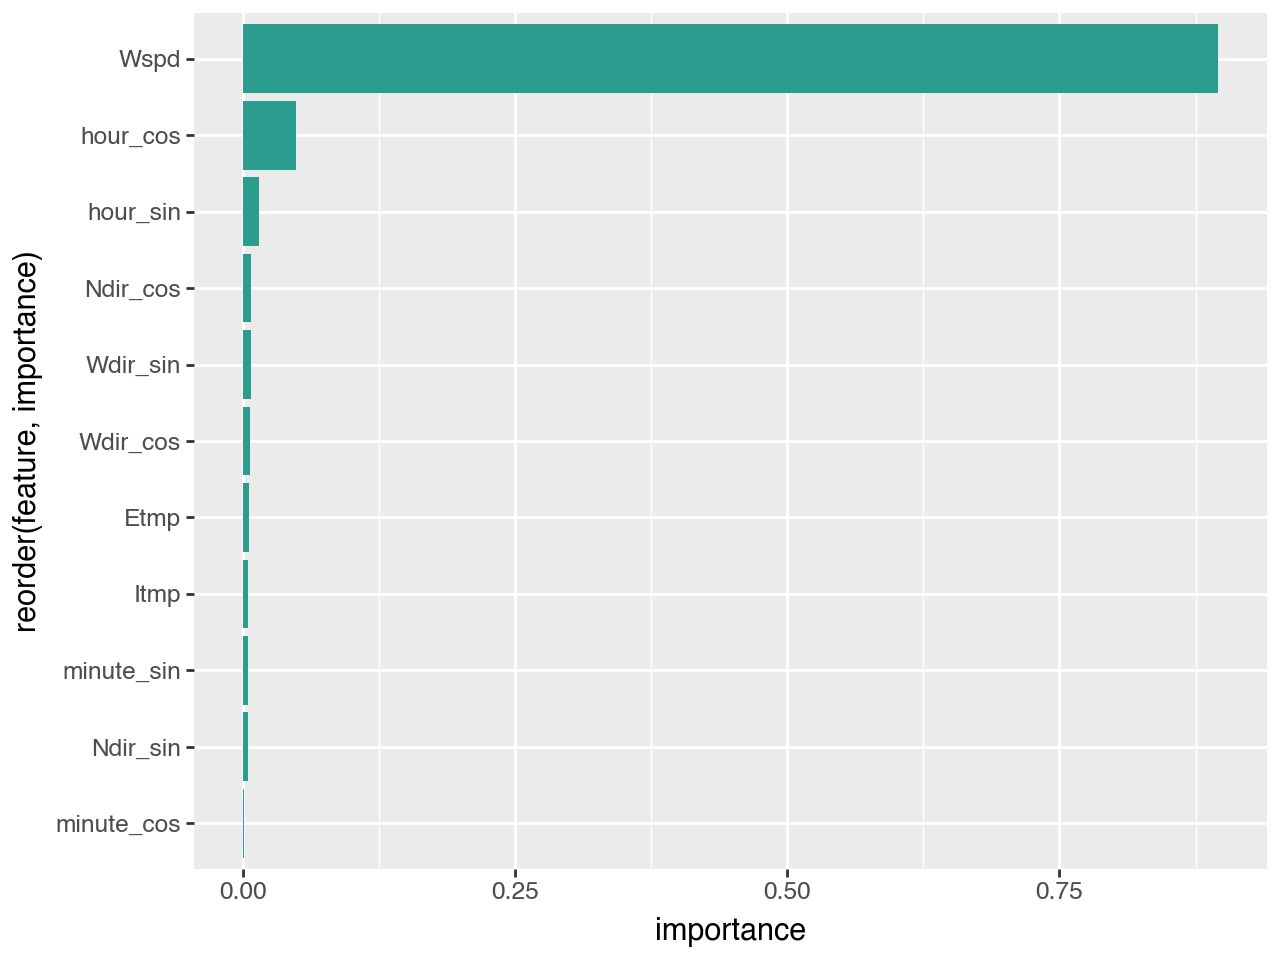

In [12]:
# most influential featyres in Ml Model

feature_importance = pd.DataFrame({
    'feature': features,
    'importance': opt.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

(
    ggplot(feature_importance, aes(x='reorder(feature, importance)', y='importance')) +
    geom_bar(stat='identity', fill='#2a9d8f') 
    + coord_flip() 
    

)

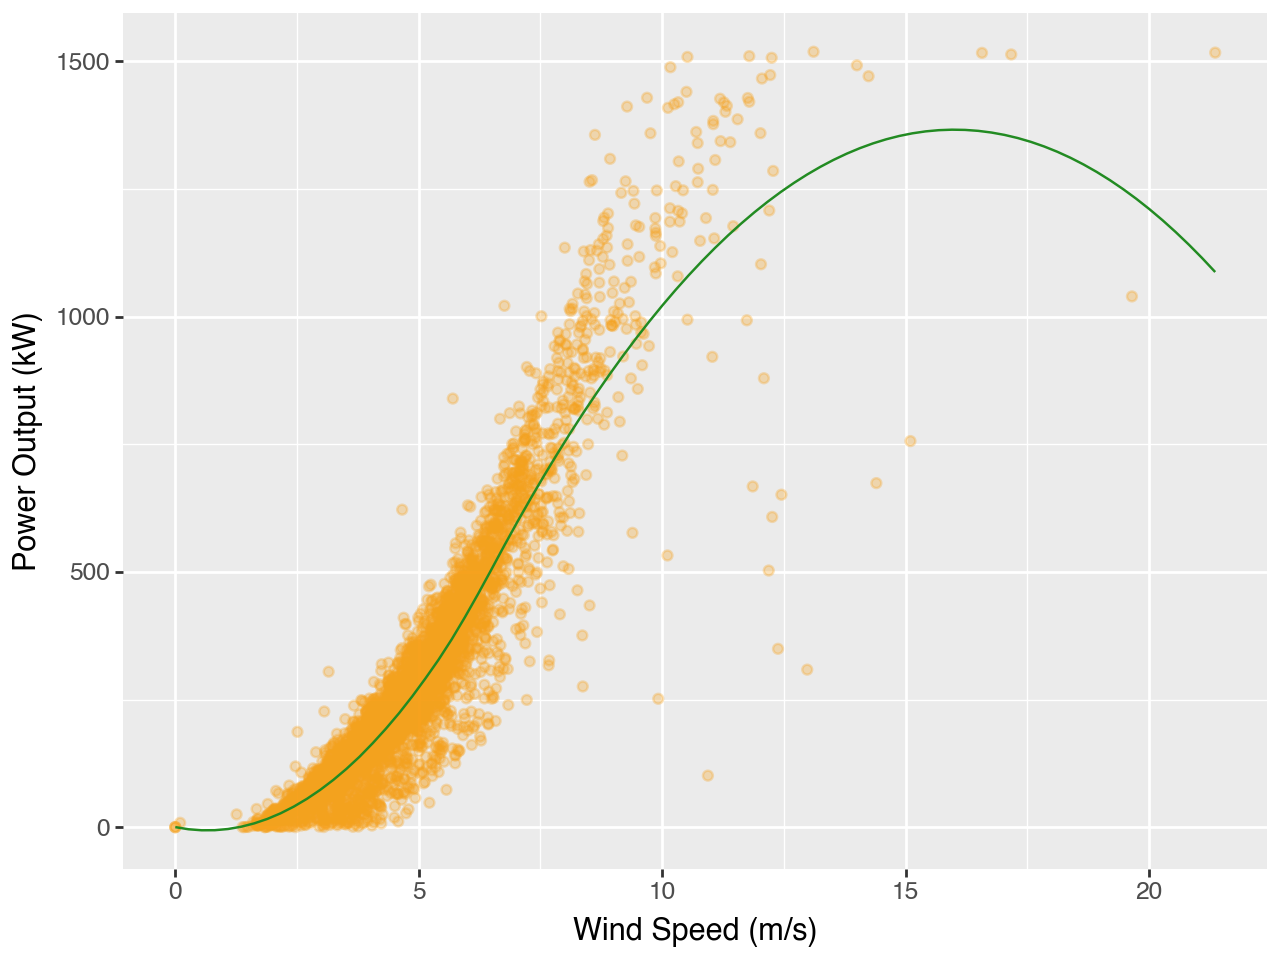

In [13]:
plot_df = df_sample[['Wspd', 'Patv']].copy()
plot_df.rename(columns={'Wspd': 'Wind Speed (m/s)', 'Patv': 'Power Output (kW)'}, inplace=True)

# plot wind speed vs power output
(
    ggplot(plot_df.sample(5000, random_state=42), aes(x='Wind Speed (m/s)', y='Power Output (kW)')) +
    geom_point(alpha=0.3, color='#F6A21E') 
    + geom_smooth(method='loess', color='forestgreen', se=False, size=.5)
)

## 2. Hydropower Forecasting

In [14]:
# Load hydropower inflow data
hydro_df = pd.read_parquet('data/AT_EFAS-3.5_vs_ENTSOE-INFLOW_2015-2019.parquet')
print(hydro_df.shape)
hydro_df.head()

(261, 189)


,year,week,entsoe_inflow,time_id,H1007,H1032,H1047,H1056,H1076,H1088,...,H822,H841,H864,H912,H927,H93,H956,H971,H990,area
0,2015.0,1.0,552130.10,2015_01,1178.85107,939.106440,898.650875,340.611328,1156.103526,49.326172,...,11396.2290,1421.97217,955.126960,898.650875,1186.059066,229.615234,468.930176,870.347160,870.347160,AT
1,2015.0,2.0,619747.00,2015_02,2034.12109,1303.292960,1340.323740,519.107418,1996.711930,74.033691,...,17445.0732,1312.05761,1161.214360,1340.323740,2068.341310,245.203122,480.729990,1547.342270,1547.342270,AT
2,2015.0,3.0,577508.20,2015_03,1158.26709,689.144529,866.427250,370.910644,1151.978030,46.605957,...,10647.7018,1324.98486,994.432130,866.427250,1163.974610,225.454589,452.821774,913.940920,913.940920,AT
3,2015.0,4.0,407744.70,2015_04,788.51465,503.528320,676.515626,295.840820,783.149406,43.155273,...,8239.1513,1229.98144,862.110340,676.515626,793.386720,213.982420,408.432621,618.167969,618.167969,AT
4,2015.0,5.0,392691.29,2015_05,582.91895,397.842775,574.859375,269.932615,579.122069,41.236328,...,6538.7910,1083.59472,805.798834,574.859375,585.428704,206.708985,383.072267,459.677728,459.677728,AT


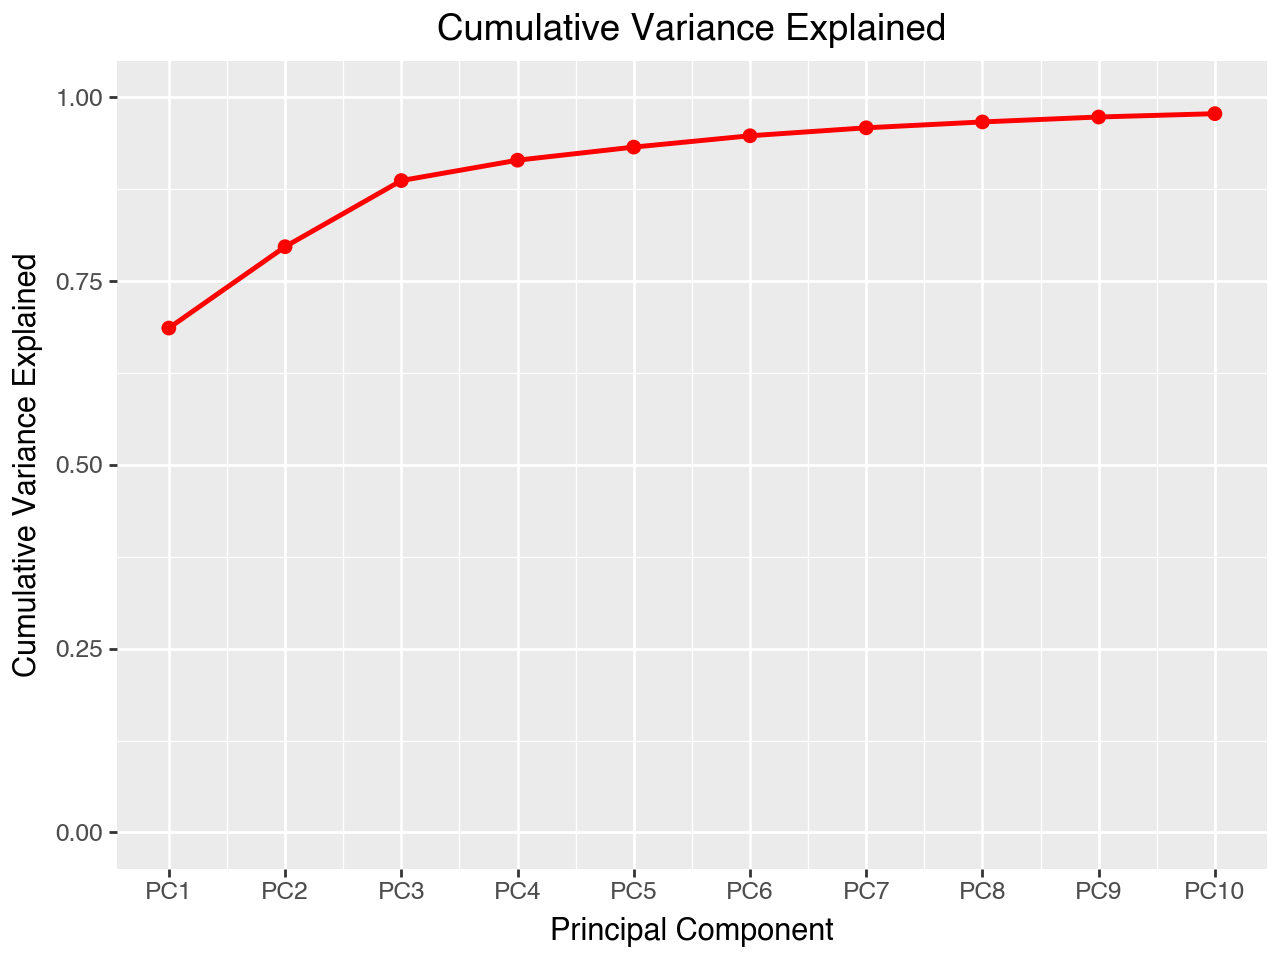

In [15]:
features = [col for col in hydro_df.columns if col.startswith('H')]

# Standardize the features
X = hydro_df.loc[:, features].values
X_scaled = StandardScaler().fit_transform(X)

# Use all components and create scree plot
pca = PCA(n_components=10).fit(X_scaled)
explained_variance = pca.explained_variance_ratio_

pc_variance_df = pd.DataFrame({
    'PC_number': range(1, len(explained_variance) + 1),
    'Variance Explained': explained_variance,
    'Cumulative Variance': explained_variance.cumsum()  
})

(
    ggplot(pc_variance_df, aes(x='PC_number', y='Cumulative Variance')) +
    geom_line(color='red', size=1) +
    geom_point(color='red', size=2) +
    scale_x_continuous(breaks=range(1, len(explained_variance) + 1),
                       labels=[f'PC{i}' for i in range(1, len(explained_variance) + 1)]) +
    scale_y_continuous(limits=[0, 1]) +
    labs(title='Cumulative Variance Explained',
         x='Principal Component',
         y='Cumulative Variance Explained')
)

In [16]:
# Random Forest model to predict hydropower inflow - hyperparameter tuning with Bayesian Optimization

split_idx = int(len(hydro_df) * 0.67)
train_data = hydro_df.iloc[:split_idx]
test_data = hydro_df.iloc[split_idx:]

scaler = StandardScaler()
X_train = scaler.fit_transform(train_data[features].values)
X_test = scaler.transform(test_data[features].values)
y_train = train_data['entsoe_inflow'].values
y_test = test_data['entsoe_inflow'].values

# Define search space
search_spaces = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical(['sqrt', 'log2', 0.5, 0.7, 1.0]),
    'bootstrap': Categorical([True, False])
}

# Create BayesSearchCV object
opt = BayesSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    search_spaces,
    n_iter=30,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    random_state=42,
    verbose=0
)

# Fit the optimizer
opt.fit(X_train, y_train)

# Best parameters
print("Best parameters:", opt.best_params_)
print("Best CV score:", -opt.best_score_)

# Evaluate on test set
y_pred = opt.predict(X_test)
print(f'\nTest Set Performance:')
print(f'MSE: {mean_squared_error(y_test, y_pred):.4f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.4f}')
print(f'R²: {r2_score(y_test, y_pred):.4f}')

Best parameters: OrderedDict([('bootstrap', True), ('max_depth', 5), ('max_features', 'log2'), ('min_samples_leaf', 10), ('min_samples_split', 20), ('n_estimators', 159)])
Best CV score: 134104.39614232923

Test Set Performance:
MSE: 9940314371.1998
MAE: 76971.6299
R²: 0.7879


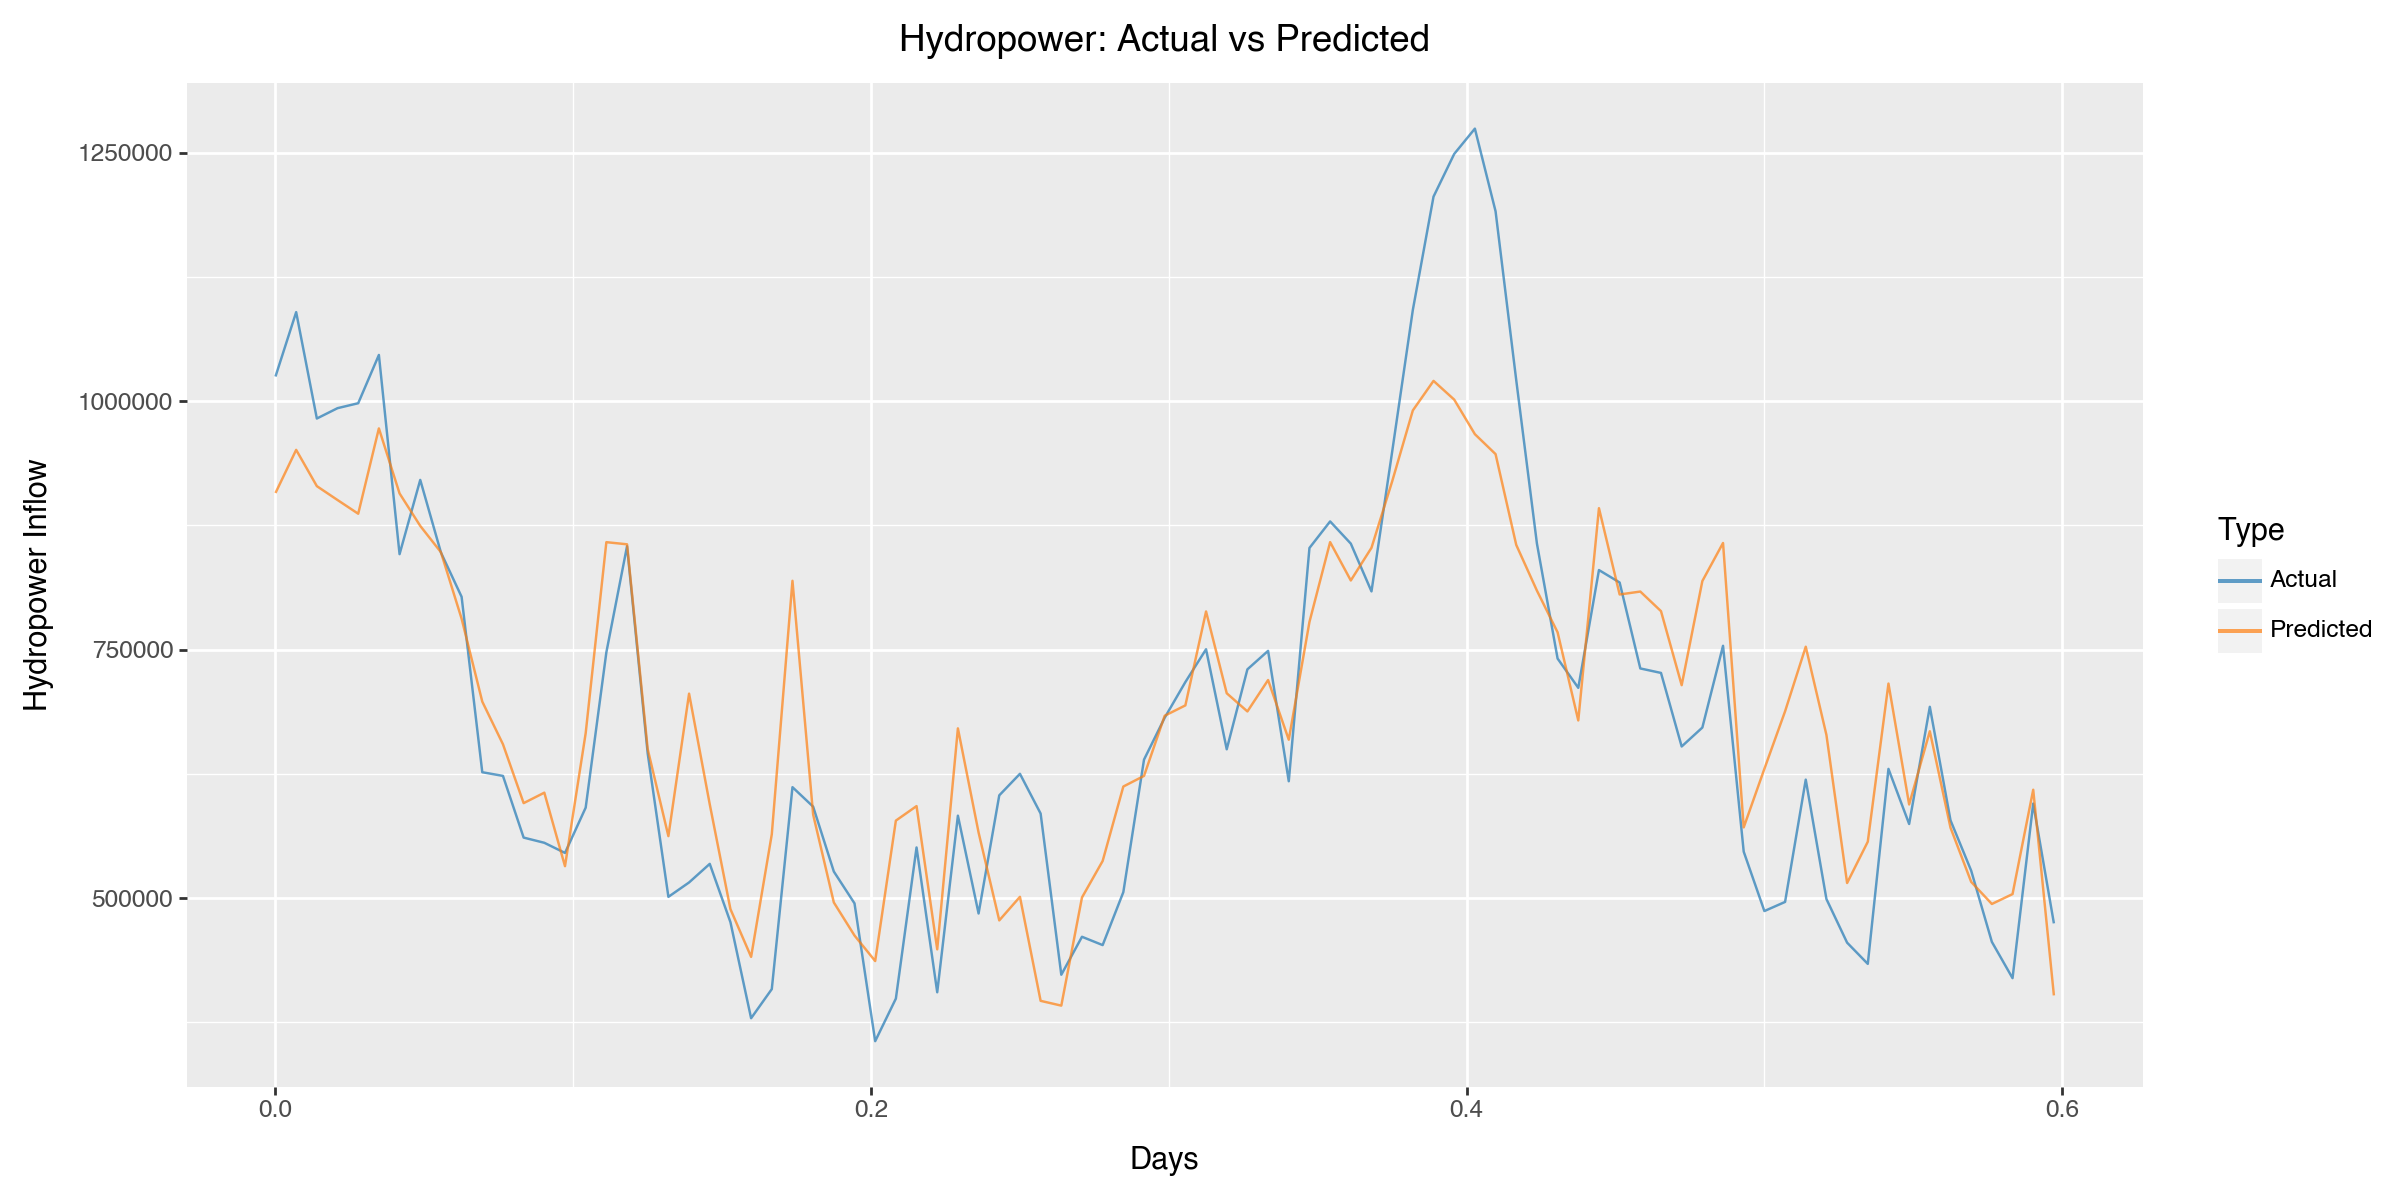

In [17]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Time_Index': range(len(y_test)),  # ← Add parentheses and length
    'Actual': y_test,
    'Predicted': y_pred
})

comparison_df['day'] = comparison_df['Time_Index'] * 10 / 60 / 24

plot_df = pd.melt(comparison_df,
                  id_vars=['day'],
                  value_vars=['Actual', 'Predicted'],
                  var_name='Type',
                  value_name='Power')

(
    ggplot(plot_df, aes(x='day', y='Power', color='Type')) +
    geom_line(alpha=0.7) +
    scale_color_manual(values=['#1f77b4', '#ff7f0e']) +
    labs(title='Hydropower: Actual vs Predicted',  # ← Updated title
         x='Days',  # ← Updated label
         y='Hydropower Inflow') +  # ← Updated label
    theme(figure_size=(12, 6))
)

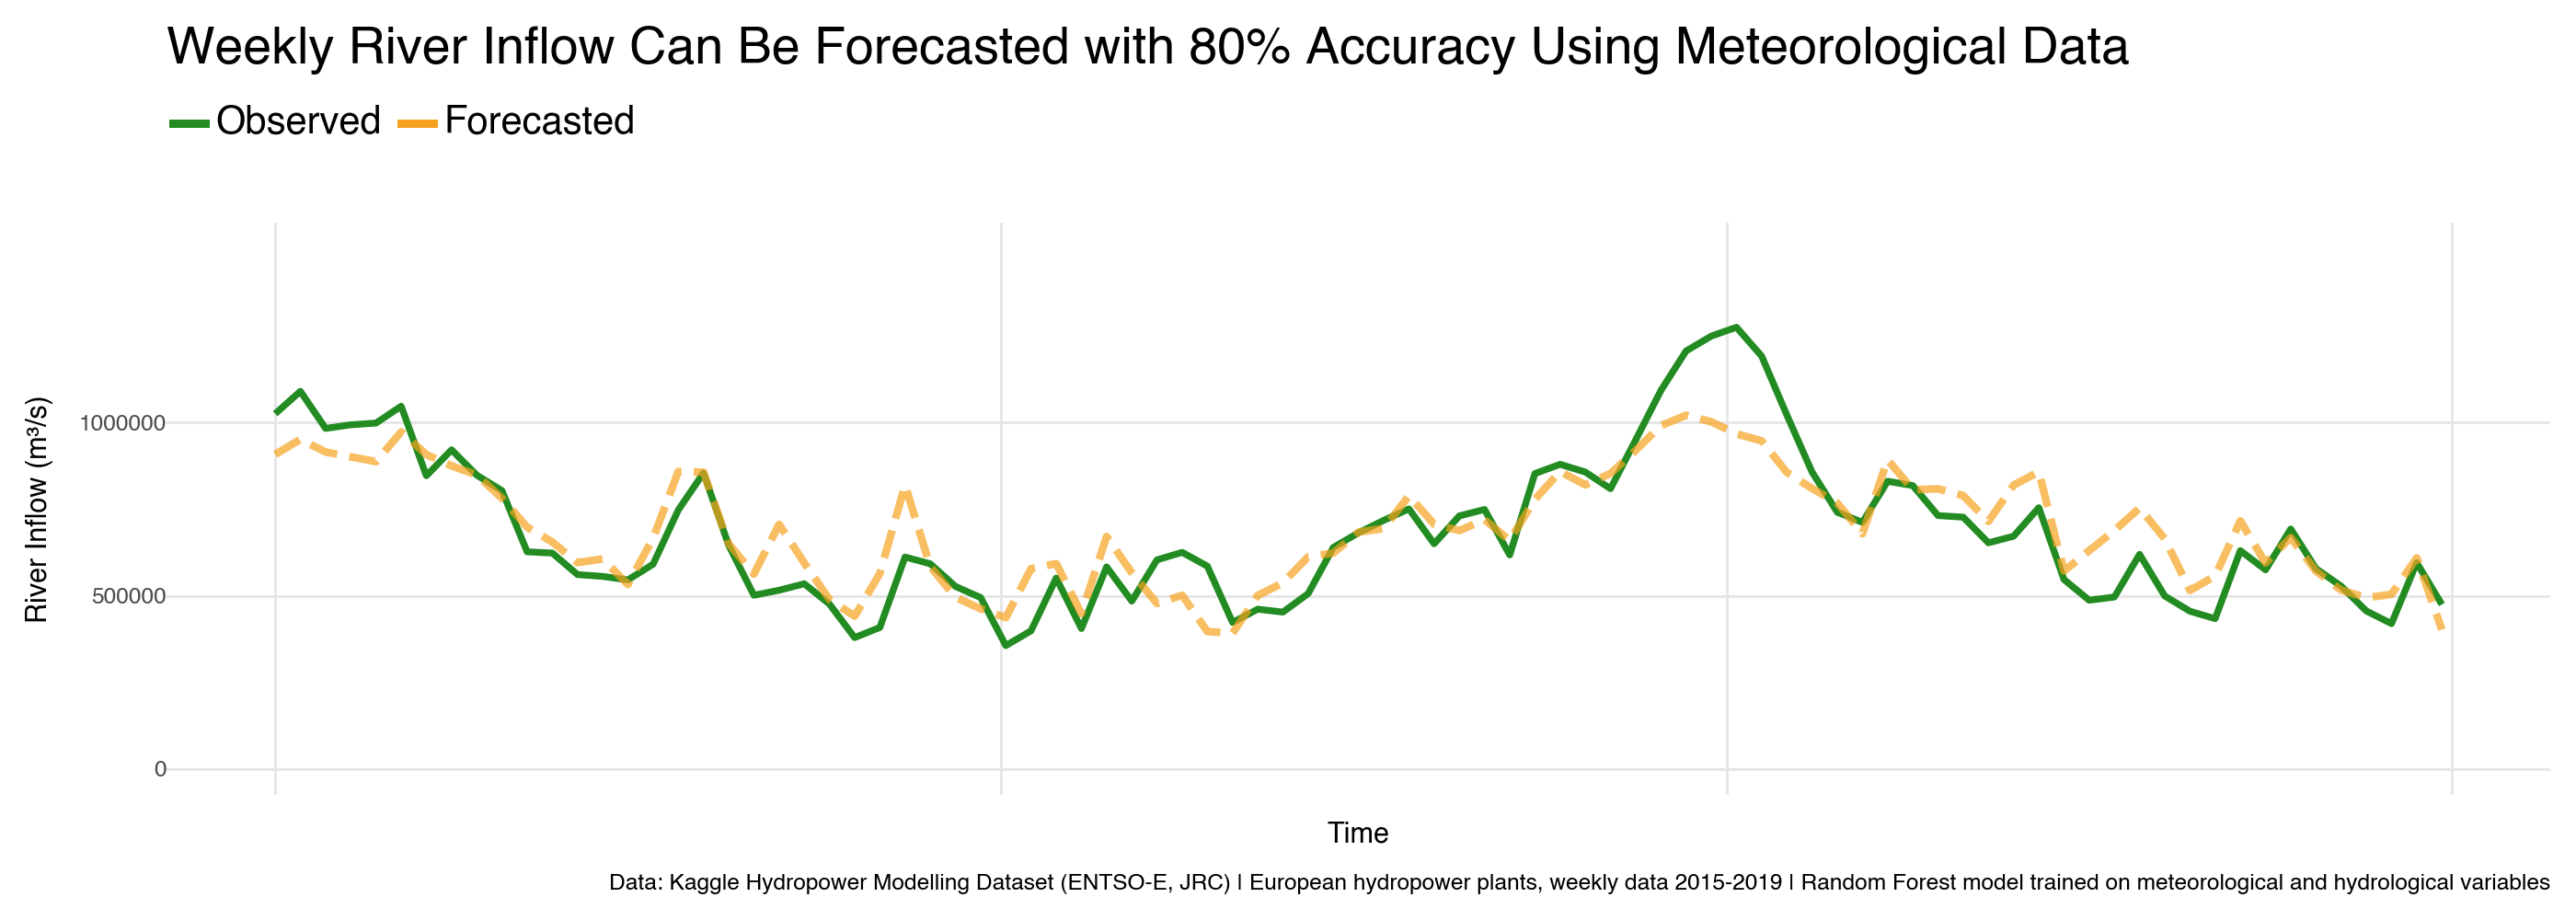

In [18]:
plot_df['Type'] = plot_df['Type'].str.replace('Actual', 'Observed')
plot_df['Type'] = plot_df['Type'].str.replace('Predicted', 'Forecasted')

plot_df['Type'] = pd.Categorical(plot_df['Type'], categories=['Observed', 'Forecasted'], ordered=True)
plot_df = plot_df.sort_values('Type')

(
    ggplot(plot_df, aes(x='day', y='Power', color='Type')) 
    + geom_line(data=plot_df[plot_df['Type']=='Observed'], size=1.5, alpha=1)
    + geom_line(data=plot_df[plot_df['Type']=='Forecasted'], size=1.7, alpha=.7, linetype='dashed')
    + scale_color_manual(values={'Observed': 'forestgreen', 'Forecasted': '#F6A21E'})
    + scale_y_continuous(limits=(0, 1500000),
                         breaks=range(0, 1500000, 500000))
    + labs(
    title = 'Weekly River Inflow Can Be Forecasted with 80% Accuracy Using Meteorological Data',
    x = 'Time',
    y = 'River Inflow (m³/s)',
    caption = ("Data: Kaggle Hydropower Modelling Dataset (ENTSO-E, JRC) | "
        "European hydropower plants, weekly data 2015-2019 | "
        "Random Forest model trained on meteorological and hydrological variables")) 
    # + scale_x_continuous(limits=(0, 7), breaks=[0, 1, 2, 3, 4, 5, 6, 7])
    + guides(fill=guide_legend(nrow=1, reverse=True))
    + theme_minimal()
    + theme(
    figure_size=(14, 5),
    plot_title=element_text(size=20, weight='bold', margin={'b': 10}, ha='left'),
    plot_subtitle=element_text(size=12, margin={'b': 20}, ha='left'),
    # axis_text_y=element_text(size=14),
    axis_title_x=element_text(size=11, margin={'t': 10}),
    axis_text_x=element_blank(),
    # axis_text_y=element_blank(),
    legend_position='top',
    legend_direction='horizontal',
    legend_box='horizontal',
    legend_title=element_blank(),
    legend_text=element_text(size=15),
    legend_justification='left',
    legend_box_just='left',
    panel_grid_minor=element_blank()
        )
)